<a href="https://colab.research.google.com/github/giseldo/neolegibilitymodel/blob/main/7764.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVR
import textstat
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [30]:
name = "7764"
filename = "../data/neo/csv/{}.csv".format(name)
df = pd.read_csv(filename)
df.head()

,issuekey,created,title,description,storypoints
0,29688087,2020-01-17 00:50:48.022,Update templates for website merge requests,Relates to &232 and #6109 \r\n\r\nGoals:\r\n\r...,1
1,29682716,2020-01-16 19:21:38.595,Make sure that we Capture Advanced Search in o...,This was raised in the PM & Engineering meetin...,1
2,29644971,2020-01-15 21:17:03.379,Propose new IA for Brand and Digital Handbook,## Goals\r\nPropose new IA for Brand and Digit...,1
3,29494181,2020-01-10 19:20:50.351,Cache `node_modules` for www-gitlab-com pipelines,# UPDATE NOTE: This MR will not be implemented...,1
4,29437529,2020-01-09 10:26:51.545,Disable all remaining unnecessary jobs in pipe...,Similar to https://gitlab.com/gitlab-com/www-g...,1


Esse conjunto de dados tem 355 User Stories.

In [31]:
df["context"] = df["title"] + df["description"]
df = df.drop(['created', 'issuekey', 'title', 'description'], axis=1)
df['context'] = df['context'].astype(str)
df.head()

,storypoints,context
0,1,Update templates for website merge requestsRel...
1,1,Make sure that we Capture Advanced Search in o...
2,1,Propose new IA for Brand and Digital Handbook#...
3,1,Cache `node_modules` for www-gitlab-com pipeli...
4,1,Disable all remaining unnecessary jobs in pipe...


Foi apagado as colunas created, issuekey, title e description.

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
storypoints,355.0,2.732394,7.186298,0.0,1.0,2.0,3.0,128.0


In [33]:
value_count = df["storypoints"].value_counts().sort_index()

Text(0, 0.5, 'Contagem de vezes')

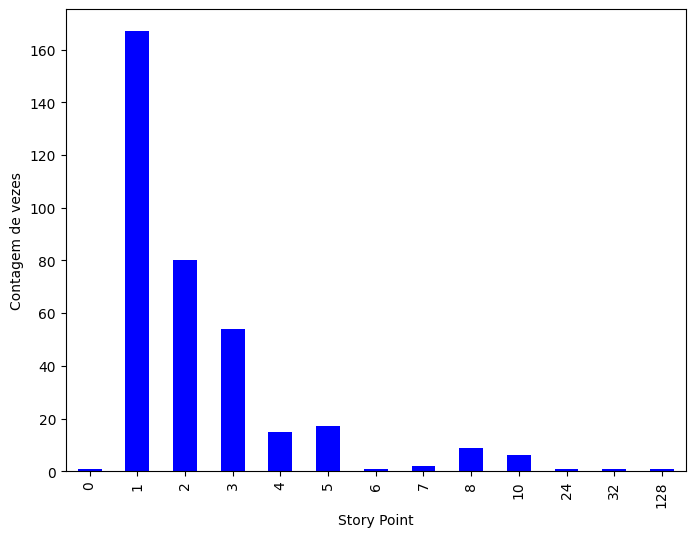

In [72]:
plt.figure(figsize=(8,6))
value_count.plot(kind='bar', color=['blue'])
plt.xlabel("Story Point")
plt.ylabel("Contagem de vezes")

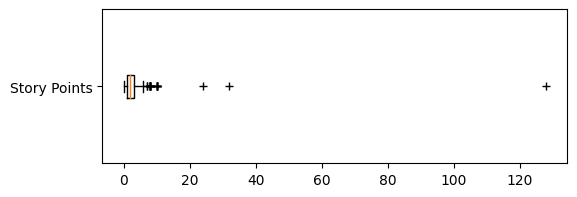

In [74]:
plt.figure(figsize=(6,2))
plt.boxplot(df['storypoints'], vert=False, sym="+")
plt.yticks([1], ['Story Points'])
plt.show()

<AxesSubplot: >

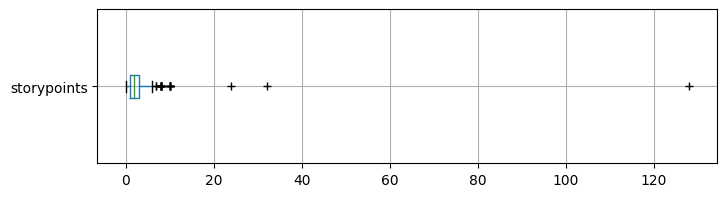

In [75]:
plt.figure(figsize=(8,2))
df.boxplot(column='storypoints', vert=False, sym="+")

In [37]:
# remover outliers
mean = df["storypoints"].mean()
std_dev = df["storypoints"].std()
outlier_cutoff = 2 * std_dev
df_clean = df[(df["storypoints"] >= mean - outlier_cutoff) & (df["storypoints"] <= mean + outlier_cutoff)]
df_clean.head()

,storypoints,context
0,1,Update templates for website merge requestsRel...
1,1,Make sure that we Capture Advanced Search in o...
2,1,Propose new IA for Brand and Digital Handbook#...
3,1,Cache `node_modules` for www-gitlab-com pipeli...
4,1,Disable all remaining unnecessary jobs in pipe...


<AxesSubplot: >

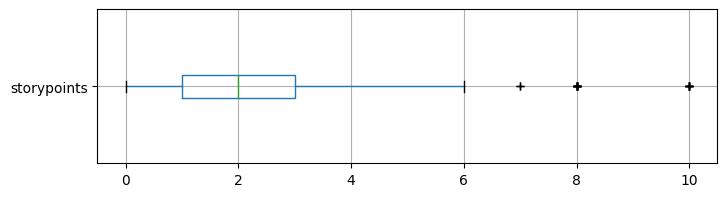

In [76]:
plt.figure(figsize=(8,2))
df_clean.boxplot(column='storypoints', vert=False, sym="+")

In [39]:
value_count_clean = df_clean["storypoints"].value_counts().sort_index()

Text(0, 0.5, 'Contagem de vezes')

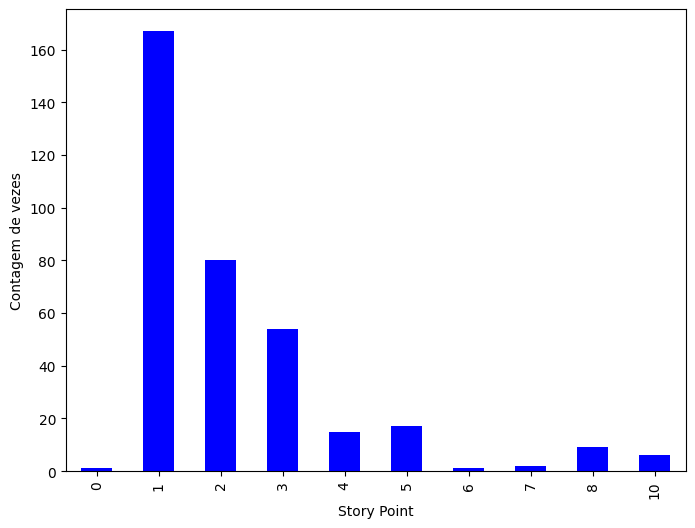

In [40]:
plt.figure(figsize=(8,6))
value_count_clean.plot(kind='bar', color=['blue'])
plt.xlabel("Story Point")
plt.ylabel("Contagem de vezes")

In [41]:
# separação treino e teste
num_linhas_treino = int(len(df_clean) * 0.7)
dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

In [42]:
storypoint_medio = dados_treino["storypoints"].mean()
storypoint_medio

2.158536585365854

Em média, nesse conjunto de dados, o Story Point Médio dos dados de treino é de 2.15

In [43]:
def mean_absolute_error(y_true, y_pred):
  """
  Calcula o Mean Absolute Error (MAE), entre os valores verdadeiros (y_true) e os valores previstos (y_pred)

  Args:
    y_true: Uma lista ou array Numpy dos valores verdadeiros.
    y_pred: Uma lista ou array NumPy dos valores previstos.

  Returns:
    mae: O Mean Absolute Error entre y_true e y_pred
  """
  if len(y_true) != len(y_pred):
    raise ValueError("Os tamanhos de y_true e y_pred devem ser iguais")
  absolute_Errors =[abs(true-pred) for true, pred in zip(y_true, y_pred)]
  mae = sum(absolute_Errors) / len(y_true)
  return mae

In [44]:
lista_y_pred = [storypoint_medio] * len(dados_teste)
mae_media_sp = mean_absolute_error(dados_teste["storypoints"], lista_y_pred)
df_results = pd.DataFrame(data=[['Media dos SP', mae_media_sp]], columns=["modelo", "MAE Teste"])
df_results

,modelo,MAE Teste
0,Media dos SP,1.319374


O MAE de treino, caso seja utilizado o Story Point Médio do dado de Treino é 1.31.

Ou seja, se sempre atribuirmos um valor de 2.15 (o Story Point Médio) a uma nova User Story ele estará em média errado 1.31 Story Point.

# Legibility Model

In [45]:
# novos atributos
colunas = ['gunning_fog', 'polarity','subjectivity']
df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
df_clean['polarity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_clean['subjectivity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
# separação treino e teste com novos atributos
num_linhas_treino = int(len(df_clean) * 0.7)
dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]
# modelo Legibility
model = SVR()
model.fit(dados_treino[colunas], dados_treino["storypoints"])
y_pred = model.predict(dados_teste[colunas])
mae_tfidf = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'Neo Legibility', 'MAE Teste': mae_tfidf}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\86824694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\86824694.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['polarity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.polarity)
C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\86824694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,modelo,MAE Teste
0,Media dos SP,1.319374
1,Neo Legibility,1.221740


# antes pré-processamento

In [46]:
df_clean.head()

,storypoints,context,gunning_fog,polarity,subjectivity
0,1,Update templates for website merge requestsRel...,8.85,0.133333,0.966667
1,1,Make sure that we Capture Advanced Search in o...,7.19,0.110714,0.366270
2,1,Propose new IA for Brand and Digital Handbook#...,17.34,0.070350,0.372007
3,1,Cache `node_modules` for www-gitlab-com pipeli...,14.98,0.086750,0.431778
4,1,Disable all remaining unnecessary jobs in pipe...,11.86,-0.133333,0.766667


In [47]:
# separação treino e teste
num_linhas_treino = int(len(df_clean) * 0.7)
dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

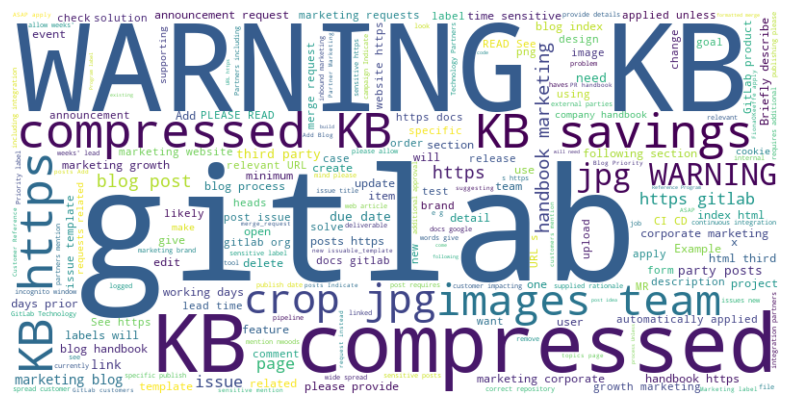

In [48]:
textos_concatenados = ' '.join(dados_treino['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_concatenados)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## atributos bow

In [49]:
vec = CountVectorizer()
bow_treino = vec.fit_transform(dados_treino['context'])
bow_df_treino = pd.DataFrame(bow_treino.toarray(), columns=vec.get_feature_names_out())
bow_df_treino

,00,000,0014m00001h35gdqaq,01,02,02_at_09,03,032,03_at_13,03_at_14,...,zamirmartinsfilho,zeffmorgan,zegerjan,zhll9r1er7ilskpzriiff3,zj,zjx5qwyfbkc,zoom,zsuzsannakovacs,zzplok3lqqwzj5u7svzujvfa,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


O bow gerou 5102 colunas, com o pré-processamento isso irá diminuir.

In [50]:
bow_teste = vec.transform(dados_teste['context'])
bow_df_teste = pd.DataFrame(bow_teste.toarray(), columns=vec.get_feature_names_out())
bow_df_teste

,00,000,0014m00001h35gdqaq,01,02,02_at_09,03,032,03_at_13,03_at_14,...,zamirmartinsfilho,zeffmorgan,zegerjan,zhll9r1er7ilskpzriiff3,zj,zjx5qwyfbkc,zoom,zsuzsannakovacs,zzplok3lqqwzj5u7svzujvfa,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,1,0,2,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# depois pre-processamento

In [51]:
# processamento do texto
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words("english"))

def remover_stopwords(texto):
  palavras = word_tokenize(texto)
  palavas_sem_stopwords = [palavra for palavra in palavras if palavra.lower() not in stop_words]
  return ' '.join(palavas_sem_stopwords)

def remover_urls(texto):
    return re.sub(r'http\S+|www\S+', ' ', texto)

def remover_html_tags(texto):
    return re.sub(r'<[^>]+>', ' ', texto)

def remover_palavras_com_numeros(texto):
    return re.sub(r'\b\w*\d\w*\b', ' ', texto)

def remover_pontuacoes(texto):
    return re.sub(r'[^\w\s]', ' ', texto)

def remover_caracteres_especiais(texto):
    return re.sub(r'[^A-Za-z0-9\s]', '', texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gigi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gigi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
# remover stopwords
df_clean["context"] = df_clean['context'].apply(remover_stopwords)
df_clean["context"] = df_clean['context'].apply(remover_urls)
df_clean["context"] = df_clean['context'].apply(remover_html_tags)
df_clean["context"] = df_clean['context'].apply(remover_palavras_com_numeros)
df_clean["context"] = df_clean['context'].apply(remover_pontuacoes)
df_clean["context"] = df_clean['context'].apply(remover_caracteres_especiais)
df_clean["context"] = df_clean["context"].str.replace(r'\s+', ' ', regex=True).str.strip()

C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\2397164545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["context"] = df_clean['context'].apply(remover_stopwords)
C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\2397164545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["context"] = df_clean['context'].apply(remover_urls)
C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\2397164545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [53]:
df_clean.head()

,storypoints,context,gunning_fog,polarity,subjectivity
0,1,Update templates website merge requestsRelates...,8.85,0.133333,0.966667
1,1,Make sure Capture Advanced Search feature feat...,7.19,0.110714,0.366270
2,1,Propose new IA Brand Digital Handbook Goals Pr...,17.34,0.070350,0.372007
3,1,Cache nodemodules pipelines UPDATE NOTE MR imp...,14.98,0.086750,0.431778
4,1,Disable remaining unnecessary jobs pipeline me...,11.86,-0.133333,0.766667


In [54]:
# separação treino e teste (após pré-processamento)
percent_treino = 0.7
num_linhas_treino = int(len(df_clean) * percent_treino)

dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

## atributos bow

In [55]:
vec = CountVectorizer()
bow_treino = vec.fit_transform(dados_treino['context'])
bow_df_treino = pd.DataFrame(bow_treino.toarray(), columns=vec.get_feature_names_out())
bow_df_treino

,aakgun,aakritigupta,aaronfriel,aashish,aasimkhan,ab,abbreviation,abbreviations,abd,abilities,...,yxous,zacbadgleycopy,zachrice,zackcuddy,zamirmartinsfilho,zeffmorgan,zegerjan,zj,zoom,zsuzsannakovacs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Reduziu para 5028 colunas, depois da remoção das stopwords, com a remoção das urls para 4600

In [56]:
bow_teste = vec.transform(dados_teste['context'])
bow_df_teste = pd.DataFrame(bow_teste.toarray(), columns=vec.get_feature_names_out())
bow_df_teste

,aakgun,aakritigupta,aaronfriel,aashish,aasimkhan,ab,abbreviation,abbreviations,abd,abilities,...,yxous,zacbadgleycopy,zachrice,zackcuddy,zamirmartinsfilho,zeffmorgan,zegerjan,zj,zoom,zsuzsannakovacs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


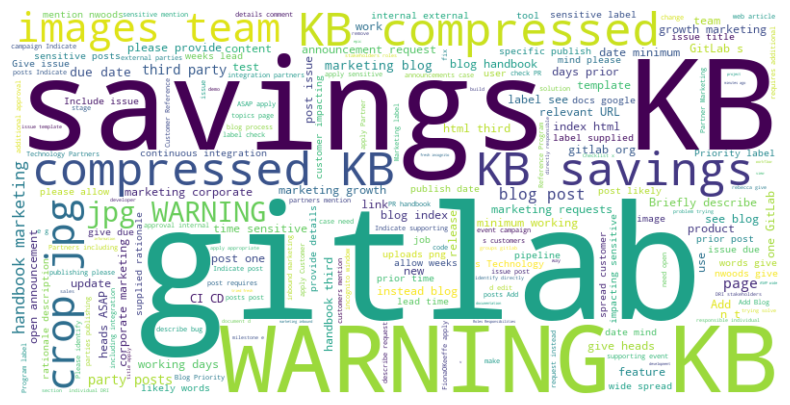

In [57]:
textos_concatenados = ' '.join(dados_treino['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_concatenados)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# modelos

In [58]:
model = SVR(kernel='linear')
model.fit(bow_df_treino, dados_treino["storypoints"])
y_pred = model.predict(bow_df_teste)
mae_bow = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'mae_bow', 'MAE Teste': mae_bow}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\2739833848.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'modelo':'mae_bow', 'MAE Teste': mae_bow}, ignore_index=True)


,modelo,MAE Teste
0,Media dos SP,1.319374
1,Neo Legibility,1.221740
2,mae_bow,1.551816


O MAE do teste para um modelo Bag-of-words é de 1.68, maior do que o MAE do teste quando usamos o Story Point Médio, de 1.35, portanto esse último modelo é um modelo pior que o baseline média selecionado.

Vamos testar um modelo com TF-IDF

# vetorização TF-IDF

In [59]:
vec = TfidfVectorizer(max_features=50)
tfidf_matrix_treino = vec.fit_transform(dados_treino["context"])
tfidf_matrix_teste = vec.transform(dados_teste["context"])

# Modelos SVM com TF-IDF

In [60]:
model = SVR(kernel='linear')
model.fit(tfidf_matrix_treino, dados_treino["storypoints"])
y_pred = model.predict(tfidf_matrix_teste)
mae_tfidf = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'mae_tfidf', 'MAE Teste': mae_tfidf}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\1988293367.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'modelo':'mae_tfidf', 'MAE Teste': mae_tfidf}, ignore_index=True)


,modelo,MAE Teste
0,Media dos SP,1.319374
1,Neo Legibility,1.221740
2,mae_bow,1.551816
3,mae_tfidf,1.247787


<AxesSubplot: ylabel='modelo'>

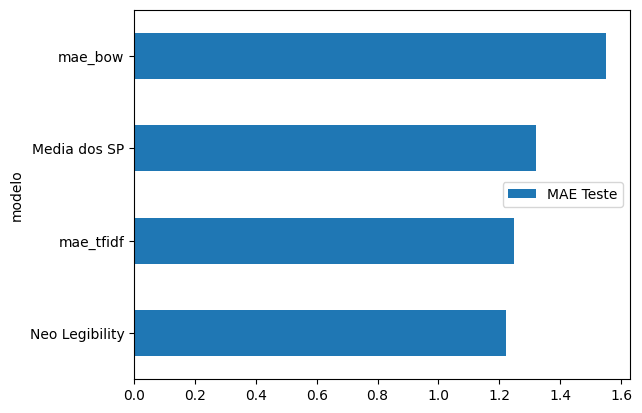

In [61]:
df_results = df_results.sort_values(by="MAE Teste")
df_results.plot.barh(y='MAE Teste', x ='modelo')

Um modelo com tfidf tem melhor capacidade que um modelo bow e que um modelo mae_medio_sp, pois tem um menor MAE.

# Modelo com legibilidade

In [62]:
df_full = pd.read_csv(filename)
df_full["context"] = df_full["title"] + df_full["description"]
df_full = df_full.drop(['created', 'issuekey', 'title', 'description'], axis=1)

# remoção outlier
mean = df_full["storypoints"].mean()
std_dev = df_full["storypoints"].std()
outlier_cutoff = 2 * std_dev
df_clean = df_full[(df_full["storypoints"] >= mean - outlier_cutoff) & (df_full["storypoints"] <= mean + outlier_cutoff)]

In [63]:
#colunas = ['gunning_fog', 'flesch_reading_ease', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index', 'linsear_write_formula', 'dale_chall_readability_score']
#colunas = ['gunning_fog', 'flesch_reading_ease', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index', 'linsear_write_formula', 'dale_chall_readability_score', 'polarity','subjectivity']
#colunas = ['polarity','subjectivity']
colunas = ['gunning_fog', 'polarity','subjectivity']
df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
df_clean['flesch_reading_ease'] = df_clean['context'].apply(textstat.flesch_reading_ease)
df_clean['flesch_kincaid_grade'] = df_clean['context'].apply(textstat.flesch_kincaid_grade)
df_clean['coleman_liau_index'] = df_clean['context'].apply(textstat.coleman_liau_index)
df_clean['automated_readability_index'] = df_clean['context'].apply(textstat.automated_readability_index)
df_clean['linsear_write_formula'] = df_clean['context'].apply(textstat.linsear_write_formula)
df_clean['dale_chall_readability_score'] = df_clean['context'].apply(textstat.dale_chall_readability_score)
df_clean['polarity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_clean['subjectivity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\2015135487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\2015135487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['flesch_reading_ease'] = df_clean['context'].apply(textstat.flesch_reading_ease)
C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\2015135487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [64]:
df_clean.head()

,storypoints,context,gunning_fog,flesch_reading_ease,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,linsear_write_formula,dale_chall_readability_score,polarity,subjectivity
0,1,Update templates for website merge requestsRel...,8.85,41.77,10.6,19.30,19.2,8.500000,13.53,0.133333,0.966667
1,1,Make sure that we Capture Advanced Search in o...,7.19,33.81,11.5,19.42,18.2,7.071429,10.00,0.110714,0.366270
2,1,Propose new IA for Brand and Digital Handbook#...,17.34,24.71,17.1,20.20,25.3,16.250000,11.38,0.070350,0.372007
3,1,Cache `node_modules` for www-gitlab-com pipeli...,14.98,51.92,12.9,12.42,17.7,16.250000,10.49,0.086750,0.431778
4,1,Disable all remaining unnecessary jobs in pipe...,11.86,43.43,12.0,14.50,15.2,12.333333,10.04,-0.133333,0.766667


In [81]:
df_clean[['gunning_fog', 'polarity', 'subjectivity', 'storypoints']].corr()

,gunning_fog,polarity,subjectivity,storypoints
gunning_fog,1.000000,0.087776,0.050378,0.170286
polarity,0.087776,1.000000,0.361146,0.029430
subjectivity,0.050378,0.361146,1.000000,-0.017237
storypoints,0.170286,0.029430,-0.017237,1.000000


In [65]:
# separação entre treino e teste
dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

In [66]:
model = SVR()
model.fit(dados_treino[colunas], dados_treino["storypoints"])
y_pred = model.predict(dados_teste[colunas])
mae_tfidf = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'mae_legibility', 'MAE Teste': mae_tfidf}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_11432\43689958.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'modelo':'mae_legibility', 'MAE Teste': mae_tfidf}, ignore_index=True)


,modelo,MAE Teste
0,Neo Legibility,1.221740
1,mae_tfidf,1.247787
2,Media dos SP,1.319374
3,mae_bow,1.551816
4,mae_legibility,1.221740


<AxesSubplot: ylabel='modelo'>

<Figure size 800x600 with 0 Axes>

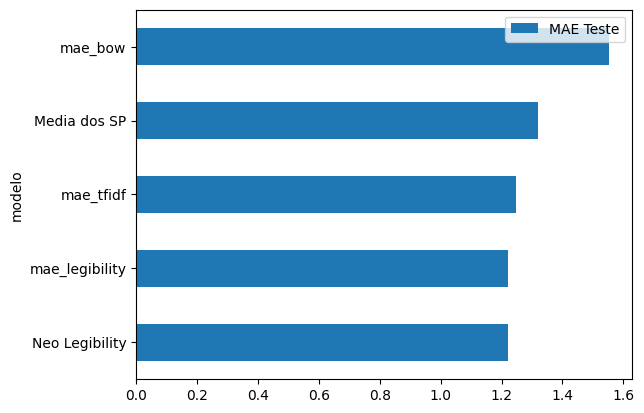

In [67]:
plt.figure(figsize=(8, 6))
df_results = df_results.sort_values(by="MAE Teste")
df_results.plot.barh(y='MAE Teste', x ='modelo')